In [1171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [1172]:
seed = 42

# Data preparation

In [1173]:
def clean_df(df):
    return df

def prep_features(df: pd.DataFrame):
    df = df.drop(["id", "status_admitere"], axis=1, errors='ignore')

    # drop irrelevant features
    df = df.drop(["gen"], axis=1)

    # dataset starts with a ","
    df.drop(["Unnamed: 0"], axis=1, inplace=True)

    df = df.select_dtypes(exclude='object')
    return df

In [1174]:
df = pd.read_csv("train_data.csv")
df = clean_df(df)

df_train = prep_features(df)

In [1175]:
df_train.head()

,NT,MEV,MATE,MGIM
0,4.91,8.82,6.23,6.85
1,9.50,7.31,8.97,8.36
2,6.23,8.63,5.40,8.54
3,1.35,9.49,9.06,5.59
4,1.82,6.71,8.67,8.34


# Exploratory data analysis

<Axes: xlabel='judet', ylabel='Count'>

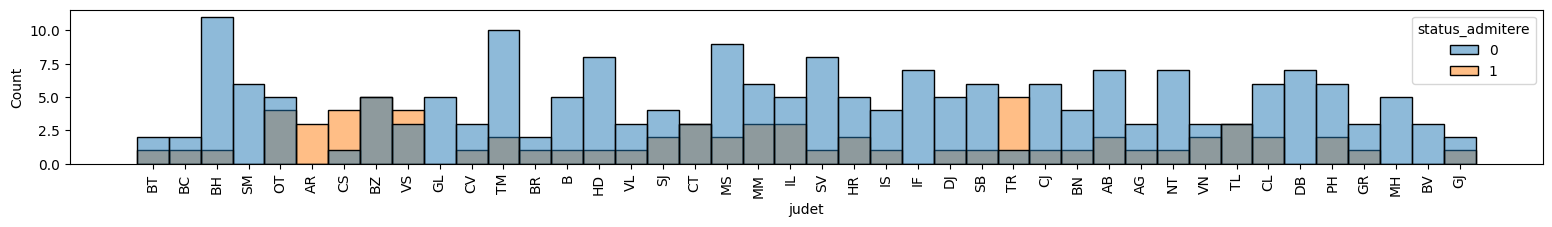

In [1176]:
plt.figure(figsize=(19, 2))
plt.xticks(rotation=90)

sns.histplot(x="judet", data=df, hue='status_admitere')

<Axes: xlabel='NT', ylabel='Count'>

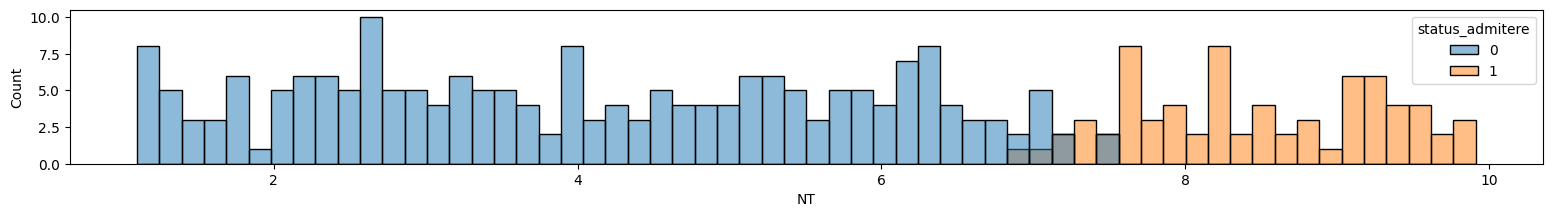

In [1177]:
plt.figure(figsize=(19, 2))

sns.histplot(x="NT", data=df, hue="status_admitere", bins=60)

# Models

In [1178]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train, df["status_admitere"], test_size=0.2, random_state=seed
)

In [1179]:
def evaluate(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
    cv = scores.mean() - scores.std()

    clf.fit(X_train, y_train)
    acc = clf.score(X_val, y_val)

    return cv, acc

In [1180]:
rf = RandomForestClassifier(n_estimators=200, random_state=seed)

evaluate(rf)

(0.9380047692277674, 0.9814814814814815)

In [1181]:
lr = LogisticRegression(max_iter=300, random_state=seed)

evaluate(lr)

(0.9674418604651163, 1.0)

<BarContainer object of 4 artists>

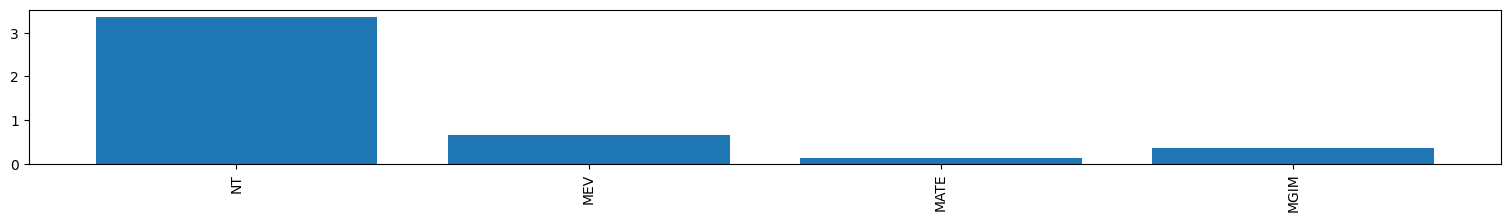

In [1182]:
plt.figure(figsize=(19, 2))
plt.xticks(rotation=90)

plt.bar(X_train.columns.values, lr.coef_[0])

In [1183]:
clf = lr

clf.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=42)

# Submission

In [1184]:
df_test = pd.read_csv("test_data.csv")
df_test = clean_df(df_test)

features = prep_features(df_test)

In [1185]:
# subtask 1
subtask1 = round(df_test["NT"] - df_test["MEV"], 2)

# ------------ subtask 2 ------------
# 1. sort by MEV descending
df2 = df_test[["id", "MEV"]].sort_values(by="MEV", ascending=False).reset_index(drop=True)

# 2. assign unique ranks 1…n
df2["rank"] = df2.index + 1

# 3. build a mapping { id → rank }
id_to_rank = dict(zip(df2["id"], df2["rank"]))

# 4. map back onto original rows
subtask2 = df_test["id"].map(id_to_rank).tolist()

# subtask 3
subtask3 = clf.predict(features)

In [1186]:
def build_subtask(subtask_id, answer):
    return pd.DataFrame({
        "subtaskID": subtask_id, "datapointID": df_test["id"], "answer": answer
    })

subtasks = [
    (subtask1, 1),
    (subtask2, 2),
    (subtask3, 3)
]

submission = pd.concat(
    [build_subtask(sid, answer) for answer, sid in subtasks],
    ignore_index=True
)

submission.head()

,subtaskID,datapointID,answer
0,1,289,3.28
1,1,312,-1.00
2,1,423,-0.69
3,1,348,-0.74
4,1,415,-4.89


In [1187]:
submission.to_csv("submission.csv", index=False)